In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('/content/sample_data/train.csv', parse_dates=['date'])
test = pd.read_csv('/content/sample_data/test.csv', parse_dates=['date'])
sample_sub = pd.read_csv('/content/sample_submission.csv')
df = pd.concat([train, test], sort=False)

In [4]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [5]:
check_df(train)

##################### Shape #####################
(227618, 4)
##################### Types #####################
date     datetime64[ns]
store             int64
item              int64
sales           float64
dtype: object
##################### Head #####################
        date  store  item  sales
0 2013-01-01      1     1   13.0
1 2013-01-02      1     1   11.0
2 2013-01-03      1     1   14.0
3 2013-01-04      1     1   13.0
4 2013-01-05      1     1   10.0
##################### Tail #####################
             date  store  item  sales
227613 2016-04-04      5    13   64.0
227614 2016-04-05      5    13   68.0
227615 2016-04-06      5    13   65.0
227616 2016-04-07      5    13   78.0
227617 2016-04-08      5     1    NaN
##################### NA #####################
date     0
store    0
item     0
sales    1
dtype: int64
##################### Quantiles #####################
       0.00  0.05  0.50   0.95   0.99   1.00
store   1.0   1.0   5.0   10.0   10.0   10.0
item  

In [6]:
check_df(test)

##################### Shape #####################
(45000, 4)
##################### Types #####################
id                int64
date     datetime64[ns]
store             int64
item              int64
dtype: object
##################### Head #####################
   id       date  store  item
0   0 2018-01-01      1     1
1   1 2018-01-02      1     1
2   2 2018-01-03      1     1
3   3 2018-01-04      1     1
4   4 2018-01-05      1     1
##################### Tail #####################
          id       date  store  item
44995  44995 2018-03-27     10    50
44996  44996 2018-03-28     10    50
44997  44997 2018-03-29     10    50
44998  44998 2018-03-30     10    50
44999  44999 2018-03-31     10    50
##################### NA #####################
id       0
date     0
store    0
item     0
dtype: int64
##################### Quantiles #####################
       0.00     0.05     0.50      0.95      0.99     1.00
id      0.0  2249.95  22499.5  42749.05  44549.01  44999.0
sto

In [7]:
check_df(df)

##################### Shape #####################
(272618, 5)
##################### Types #####################
date     datetime64[ns]
store             int64
item              int64
sales           float64
id              float64
dtype: object
##################### Head #####################
        date  store  item  sales  id
0 2013-01-01      1     1   13.0 NaN
1 2013-01-02      1     1   11.0 NaN
2 2013-01-03      1     1   14.0 NaN
3 2013-01-04      1     1   13.0 NaN
4 2013-01-05      1     1   10.0 NaN
##################### Tail #####################
            date  store  item  sales       id
44995 2018-03-27     10    50    NaN  44995.0
44996 2018-03-28     10    50    NaN  44996.0
44997 2018-03-29     10    50    NaN  44997.0
44998 2018-03-30     10    50    NaN  44998.0
44999 2018-03-31     10    50    NaN  44999.0
##################### NA #####################
date          0
store         0
item          0
sales     45001
id       227618
dtype: int64
##################

In [8]:
#How is the sales distribution?
df["sales"].describe([0.10, 0.30, 0.50, 0.70, 0.80, 0.90, 0.95, 0.99])

count    227617.000000
mean         52.645633
std          28.717892
min           0.000000
10%          18.000000
30%          33.000000
50%          50.000000
70%          66.000000
80%          77.000000
90%          92.000000
95%         105.000000
99%         129.000000
max         210.000000
Name: sales, dtype: float64

In [9]:
# How many stores are there?
df[["store"]].nunique()

store    10
dtype: int64

In [10]:
# How many items are there?
df[["item"]].nunique()

item    50
dtype: int64

In [11]:
# Are there an equal number of unique items in each store?
df.groupby(["store"])["item"].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

In [12]:
# So, is there an equal number of sales in each store?
df.groupby(["store", "item"]).agg({"sales": ["sum"]})

sales
                sum
store item         
1     1     36468.0
      2     97050.0
      3     60638.0
      4     36440.0
      5     30335.0
...             ...
10    46        0.0
      47        0.0
      48        0.0
      49        0.0
      50        0.0

[500 rows x 1 columns]

In [13]:
# sales statistics in store-item breakdown
df.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
                sum       mean median        std
store item                                      
1     1     36468.0  19.971522   19.0   6.741022
      2     97050.0  53.148959   52.0  15.005779
      3     60638.0  33.208105   33.0  10.072529
      4     36440.0  19.956188   20.0   6.640618
      5     30335.0  16.612815   16.0   5.672102
...             ...        ...    ...        ...
10    46        0.0        NaN    NaN        NaN
      47        0.0        NaN    NaN        NaN
      48        0.0        NaN    NaN        NaN
      49        0.0        NaN    NaN        NaN
      50        0.0        NaN    NaN        NaN

[500 rows x 4 columns]

In [14]:
def create_date_features(df):
    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.weekofyear
    df['day_of_week'] = df.date.dt.dayofweek
    df['year'] = df.date.dt.year
    df["is_wknd"] = df.date.dt.weekday // 4
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    return df

In [15]:
df = create_date_features(df)

In [16]:
df.groupby(["store", "item", "month"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                            
                     sum       mean median       std
store item month                                    
1     1    1      2125.0  13.709677   13.0  4.397413
           2      2063.0  14.631206   14.0  4.668146
           3      2728.0  17.600000   17.0  4.545013
           4      3118.0  20.786667   20.0  4.894301
           5      3448.0  22.245161   22.0  6.564705
...                  ...        ...    ...       ...
10    49   2         0.0        NaN    NaN       NaN
           3         0.0        NaN    NaN       NaN
      50   1         0.0        NaN    NaN       NaN
           2         0.0        NaN    NaN       NaN
           3         0.0        NaN    NaN       NaN

[2625 rows x 4 columns]

In [ ]:
# Random Noise

# At this point, we add random noise to the variables that we will produce in the sales focus in order to prevent over-learning or to prevent bias. This will add noise prevents over-learning.


# Lag/Shifted Features

In [17]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

In [18]:
df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)

In [19]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

In [20]:
df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728,31, 62, 142, 172, 202, 232, 262, 292,312,342])


# Rolling Mean Features

# Rolling Mean means moving average. These moving averages carry historical information. We will create them to put Level and Trend components. window represents the number of delay. The entered value takes the delay with itself and calculates the average.

# At this point, the own value of the observation unit should not be taken into account when calculating the moving average,

# but in this case, a feature independent of the current value can be produced that can express the trend from the past.


In [21]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe

In [24]:
df = roll_mean_features(df, [180, 365, 546, 728, 910])
df.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_lag_31,sales_lag_62,sales_lag_142,sales_lag_172,sales_lag_202,sales_lag_232,sales_lag_262,sales_lag_292,sales_lag_312,sales_lag_342,sales_roll_mean_365,sales_roll_mean_546,sales_roll_mean_180,sales_roll_mean_728,sales_roll_mean_910
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Exponentially Weighted Mean Features

# We know that the weighted average gives more weight to values close to the past. When the alpha is .99 it will give more weight to the nearest values, when it is 0.1 it will give more weight to the far values. In this example,

# we observe that as the weight of the past values increases, it approaches the normal mean value.

In [25]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

In [26]:
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728,31, 62, 142, 172, 202, 232, 262, 292,312,342]


df = ewm_features(df, alphas, lags)

# One-Hot Encoding

In [27]:
df = pd.get_dummies(df, columns=['store', 'item', 'day_of_week', 'month'])

# Since we will use lightgbm, one of the tree methods, we may prefer to log the dependent variable in order to make the gradient descent algorithm work faster.


# Converting sales to log(1+sales)

In [28]:
df['sales'] = np.log1p(df["sales"].values)
check_df(df)

##################### Shape #####################
(272618, 209)
##################### Types #####################
date            datetime64[ns]
sales                  float64
id                     float64
day_of_month             int64
day_of_year              int64
                     ...      
month_8                  uint8
month_9                  uint8
month_10                 uint8
month_11                 uint8
month_12                 uint8
Length: 209, dtype: object
##################### Head #####################
        date     sales  id  day_of_month  day_of_year  week_of_year  year  is_wknd  is_month_start  is_month_end  sales_lag_91  sales_lag_98  sales_lag_105  sales_lag_112  sales_lag_119  sales_lag_126  sales_lag_182  sales_lag_364  sales_lag_546  sales_lag_728  sales_lag_31  sales_lag_62  sales_lag_142  sales_lag_172  sales_lag_202  sales_lag_232  sales_lag_262  sales_lag_292  sales_lag_312  sales_lag_342  sales_roll_mean_365  sales_roll_mean_546  sales_roll_mean_1


# Model




########################
# Custom Cost Function
########################

# MAE: mean absolute error
# MAPE: mean absolute percentage error
# SMAPE: Symmetric mean absolute percentage error (adjusted MAPE)

# SMAPE (Symmetric Mean Absolute Error) or MAPE allows us to evaluate the errors as a percentage. Returns a metric from 0-100.
# The expm1() function reverses the log transformation.

In [29]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val

def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

# Time-Based Validation Sets

In [31]:
# Train set until the beginning of 2017 ( end of 2016).
train = df.loc[(df["date"] < "2017-01-01"), :]

val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]

cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

Y_train = train['sales']
X_train = train[cols]

Y_val = val['sales']
X_val = val[cols]

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((182358,), (182358, 205), (11160,), (11160, 205))

# At this point, we cannot separate the data set with train test split, because this function pulls random values

# from the data, thus distorting the context and structure of the time series. For this, we separate the dataset ourselves.

In [32]:
# LightGBM parameters
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 1000,
              'early_stopping_rounds': 200,
              'nthread': -1}

In [33]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape,
                  verbose_eval=100)

y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

smape(np.expm1(y_pred_val), np.expm1(Y_val))


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: nan	training's SMAPE: 199.998	valid_1's l1: 3.70025	valid_1's SMAPE: 200
[200]	training's l1: nan	training's SMAPE: 199.998	valid_1's l1: 3.70025	valid_1's SMAPE: 200
Early stopping, best iteration is:
[1]	training's l1: nan	training's SMAPE: 199.998	valid_1's l1: 3.70025	valid_1's SMAPE: 200


200.0

# Normally we used lightgbm from within sklearn. Here we used Microsoft's own lightgbm, but for this the model requires
# its own data type. With lgb.Dataset, we can convert this data to the desired data type.

# Final Model

In [34]:
def plot_lgb_importances(model, plot=False, num=10):

    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))


                        feature  split       gain
78    sales_ewm_alpha_08_lag_31      3  58.603884
59    sales_ewm_alpha_09_lag_31      2  39.093450
0                  day_of_month      4   2.302666
107   sales_ewm_alpha_05_lag_91      0   0.000000
108   sales_ewm_alpha_05_lag_98      0   0.000000
132                     store_7      0   0.000000
133                     store_8      0   0.000000
134                     store_9      0   0.000000
135                    store_10      0   0.000000
136                      item_1      0   0.000000
137                      item_2      0   0.000000
138                      item_3      0   0.000000
139                      item_4      0   0.000000
140                      item_5      0   0.000000
141                      item_6      0   0.000000
142                      item_7      0   0.000000
143                      item_8      0   0.000000
144                      item_9      0   0.000000
145                     item_10      0   0.000000


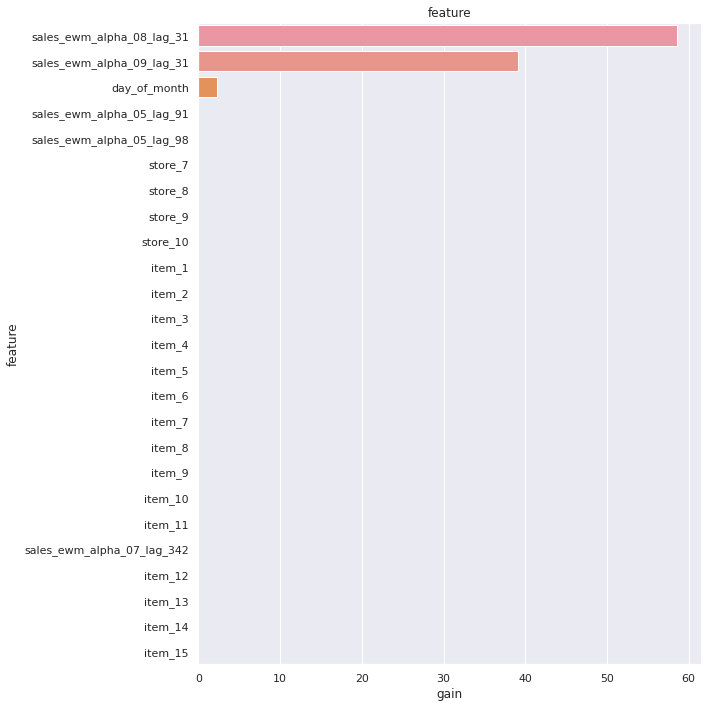

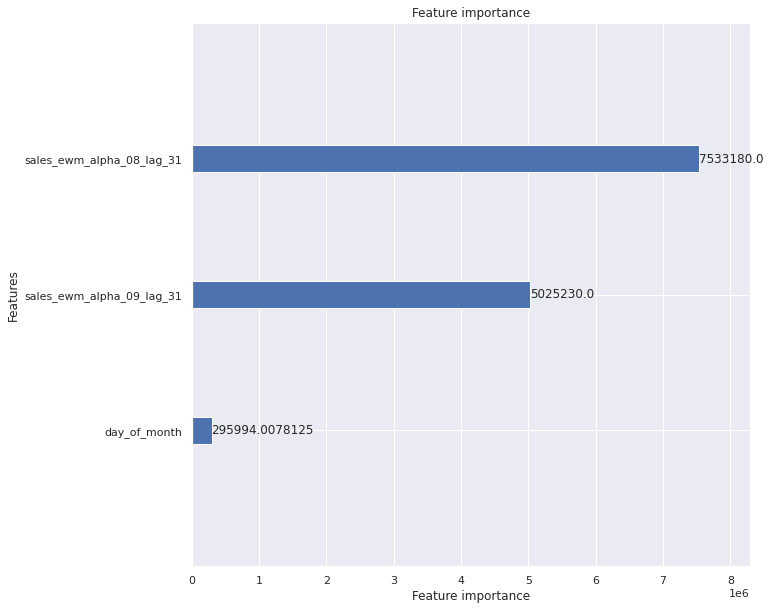

In [35]:
plot_lgb_importances(model, num=30)
plot_lgb_importances(model, num=30, plot=True)

lgb.plot_importance(model, max_num_features=20, figsize=(10, 10), importance_type="gain")
plt.show()

In [44]:
lgb_params = {'num_leaves':10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 1500,
              'early_stopping_rounds': 200,
              'nthread': -1}


In [45]:
lgbtrain = lgb.Dataset(data = X_train, label = Y_train, feature_name=cols)
lgbval = lgb.Dataset(data = X_val, label = Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets = [lgbtrain, lgbval],
                  num_boost_round = lgb_params['num_boost_round'],
                  early_stopping_rounds = lgb_params['early_stopping_rounds'],
                  feval = lgbm_smape,
                  verbose_eval = 100)

Training until validation scores don't improve for 200 rounds.
[100]	training's SMAPE: 17.1667	valid_1's SMAPE: 16.8638
[200]	training's SMAPE: 14.3049	valid_1's SMAPE: 14.5073
[300]	training's SMAPE: 13.7526	valid_1's SMAPE: 14.1423
[400]	training's SMAPE: 13.5192	valid_1's SMAPE: 14.0104
[500]	training's SMAPE: 13.3711	valid_1's SMAPE: 13.9086
[600]	training's SMAPE: 13.2714	valid_1's SMAPE: 13.8252
[700]	training's SMAPE: 13.1973	valid_1's SMAPE: 13.7545
[800]	training's SMAPE: 13.142	valid_1's SMAPE: 13.7018
[900]	training's SMAPE: 13.0979	valid_1's SMAPE: 13.6601
[1000]	training's SMAPE: 13.0617	valid_1's SMAPE: 13.6209
[1100]	training's SMAPE: 13.03	valid_1's SMAPE: 13.5879
[1200]	training's SMAPE: 13.0021	valid_1's SMAPE: 13.5593
[1300]	training's SMAPE: 12.9774	valid_1's SMAPE: 13.5316
[1400]	training's SMAPE: 12.955	valid_1's SMAPE: 13.5067
[1500]	training's SMAPE: 12.9347	valid_1's SMAPE: 13.4847
Did not meet early stopping. Best iteration is:
[1500]	training's SMAPE: 12.9347

In [46]:
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

smape(np.expm1(y_pred_val), np.expm1(Y_val)) 

13.484696621500085

In [47]:
def plot_lgb_importances(model, plot=False, num=10):

    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))




                         feature  split       gain
116    sales_ewm_alpha_05_lag_31    391  26.875467
29           sales_roll_mean_728    383  26.729417
30           sales_roll_mean_910    354  19.617075
13                 sales_lag_364   1400  11.018449
125   sales_ewm_alpha_05_lag_342    269   3.803678
113   sales_ewm_alpha_05_lag_365    328   2.525676
3                        is_wknd    253   1.499174
27           sales_roll_mean_546    441   1.253557
186                day_of_week_0    276   0.951268
1                    day_of_year   1079   0.776750
96    sales_ewm_alpha_07_lag_728    113   0.696956
204                     month_12    307   0.580249
117    sales_ewm_alpha_05_lag_62    177   0.547624
77    sales_ewm_alpha_08_lag_728     31   0.288841
192                day_of_week_6    172   0.216263
94    sales_ewm_alpha_07_lag_365    108   0.196355
115   sales_ewm_alpha_05_lag_728    279   0.193140
58    sales_ewm_alpha_09_lag_728     23   0.164208
2                   week_of_yea

In [48]:
plot_lgb_importances(model, num=30)

                         feature  split       gain
116    sales_ewm_alpha_05_lag_31    391  26.875467
29           sales_roll_mean_728    383  26.729417
30           sales_roll_mean_910    354  19.617075
13                 sales_lag_364   1400  11.018449
125   sales_ewm_alpha_05_lag_342    269   3.803678
113   sales_ewm_alpha_05_lag_365    328   2.525676
3                        is_wknd    253   1.499174
27           sales_roll_mean_546    441   1.253557
186                day_of_week_0    276   0.951268
1                    day_of_year   1079   0.776750
96    sales_ewm_alpha_07_lag_728    113   0.696956
204                     month_12    307   0.580249
117    sales_ewm_alpha_05_lag_62    177   0.547624
77    sales_ewm_alpha_08_lag_728     31   0.288841
192                day_of_week_6    172   0.216263
94    sales_ewm_alpha_07_lag_365    108   0.196355
115   sales_ewm_alpha_05_lag_728    279   0.193140
58    sales_ewm_alpha_09_lag_728     23   0.164208
2                   week_of_yea

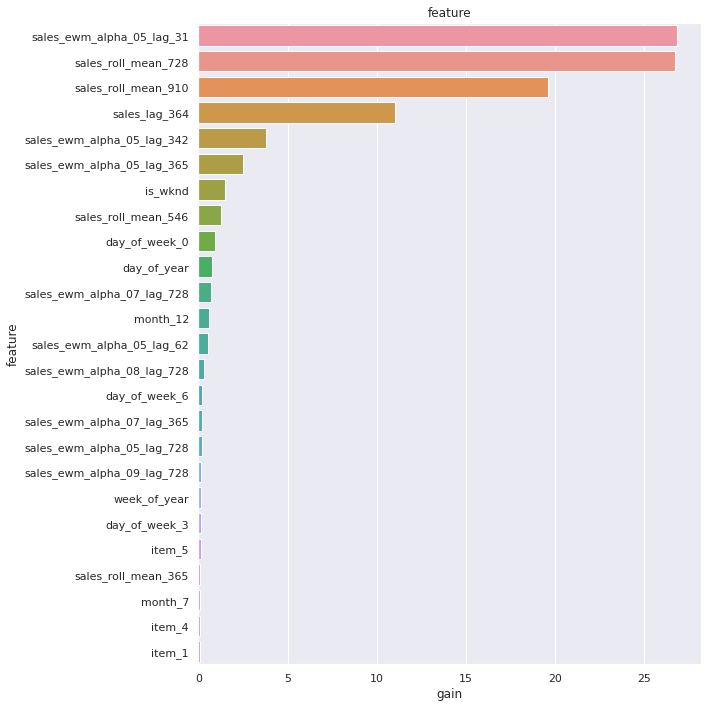

In [49]:
plot_lgb_importances(model, plot=True, num=30)


In [50]:
train = df.loc[~df.sales.isna()]  # df icerisinde NA olmayan gozlemler train setine karsilik geliyor


In [51]:
Y_train = train['sales']
X_train = train[cols]

test = df.loc[df.sales.isna()]
X_test = test[cols]

In [52]:
lgb_params = {'num_leaves':10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': model.best_iteration,
              'nthread': -1}


In [53]:
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration) # Train islemini baslatiyoruz

test_preds = model.predict(X_test, num_iteration=model.best_iteration)

In [56]:
submission_df = test.loc[:, ['id','sales']]
submission_df['sales'] = np.expm1(test_preds)
submission_df.to_csv('submission_demand.csv', index=False)
submission_df.head(20)

,id,sales
0,0.0,12.623673
1,1.0,14.546038
2,2.0,14.998200
3,3.0,15.969161
4,4.0,16.922593
5,5.0,17.884264
6,6.0,20.412297
7,7.0,12.419059
8,8.0,15.393634
9,9.0,14.620821
